In [44]:
import scipy
from scipy import sparse
import numpy as np 
import sklearn 
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import metrics

import matplotlib.pyplot as plt

import sys
import pickle


import crud_operations as co

## Get pl_queries from db


In [2]:
def processQueries():
    db = co.MySQLDB('pl_queries')
    
    queries = {}
    res = db.readAllQueries()
    for q in res:
        queries[int(q[0])] = [q[2], q[3]]
    return queries

queries = processQueries()

query_text=[queries[x][1] for x in queries]
print(len(queries))

1418


## Definitions 

In [112]:
# given data, return list of clusters 
def kmeans(data, NUM_CLUSTERS):
    km = KMeans(n_clusters=NUM_CLUSTERS)
    km.fit(data)

    clusters = km.labels_.tolist()
    x = np.asarray(clusters)
    
    # testing bincount 
    # can compare to q_dic to see questions distribution 
    nc=get_num_clusters(x)
    print("Distribution of clusters: " + str(len(nc)))
    print(nc)
    
    return x

def mean_shift(data):
    clustering = MeanShift().fit(data)
    
    x=clustering.labels_
    nc=get_num_clusters(x)
    print("Distribution of clusters: " + str(len(nc)))
    print(nc)
    
    
    
#     num_clusters=len(temp)
#     plt.title("Number of queries in each cluster")
#     plt.xlabel("Cluster Id")
#     plt.bar(np.arange(num_clusters),np.bincount(clustering.labels_))
    
    return x

def agglom(data, dist, link):
    # FIX: CURRENT VERSION OF SKLEARN DOESNT ALLOW FOR NONE CLUSTERS 
    # because distance_threshold isn't an attribute...???
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist, linkage=link).fit(data)
    x=clustering.labels_
    nc=get_num_clusters(x)
    print("Distribution of clusters: " + str(len(nc)))
    print(nc)
    
    return x

### Utils

In [4]:
# given a variantID, get all queries and embeddings
# for that ID 

def get_clustering_input(emb):
    data=[]
    qids=[]

    for key in emb:
        qids.append(key)
        data.append(emb[key])
    return data, qids

def get_num_clusters(clusters):
    counter={}
    for i in clusters:
        if i in counter: 
            counter[i]+=1
        else:
            counter[i] = 1
    return counter

def get_question_queries(queries, variant, emb):
    variant_qids=[]
    for q in queries:
        if queries[q][0] == variant:
            variant_qids.append(q)
            
    subset_embs={}
    for e in emb:
        if e in variant_qids:
            subset_embs[e]=emb[e]
            
    data, qids=get_clustering_input(subset_embs)
    
    return data, qids

def get_ari(x, labels):
    ari = metrics.adjusted_rand_score(labels, x) 
    print("ARI index: " + str(ari))

analysis for paper

In [5]:
keywords = ["group by", "natural join"]

count=0
word="natural join"
for q in query_text:
#     words=q.split(" ")
#     sels=0
#     for w in words:
#         if "select" in w.lower():
#             sels+=1
#     if sels>2:
#         count+=1     
    if "group by" in q.lower() and "having" in q.lower():
        count+=1
print(word, count)
        

natural join 157


# Clustering 

In [6]:
# number of queries per Q 
variant_counts={}
for key in queries:
    variant=queries[key][0]
    if variant in variant_counts:
        variant_counts[variant]+=1
    else:
        variant_counts[variant]=1

It looks like mean shift clustering gave us the best results for clustering by questionId. The accuracy of that method is easier to track becuase we had the labels (questionIDs). For the next section, results will be based on qualitative results--i.e., how closely do the queries within each cluster resemble eachother? 

## Clustering by question ID

1. Define functions 
2. Cluster 
3. View clusters 
4. Print JSON 
5. Additional Analysis

### 1. Define functions

In [8]:
# get rid of all questions with less than 8 queries...
all_variants=[x for x in variant_counts if variant_counts[x] >= 8]

In [113]:
def get_all_clusters(name, n_clusters=6, dist=0.35, link='ward'):

    # variant --> [query]
    all_labels={}
    
    # variant --> [cluster assignments]
    all_clusters={}
    
    
    for v in all_variants: 
        data,qids=get_question_queries(queries, v, emb)
        all_labels[v] = qids
        
        print("Question: " + str(v) +", "+str(len(all_labels[v])) + " queries.")
        clustering=""
        if name =="kmeans": 
            clustering=kmeans(data, n_clusters)
        elif name=="mean_shift":
            clustering=mean_shift(data)
        elif name=="agglomerative":
            clustering=agglom(data, dist, link)
            
        try:
            score = silhouette_score(data, clustering)
            print("Silhouette score: %0.3f" %score)
        except: 
            print("Silhouette score: N/A. Only one cluster predicted")
        
        print("\n")
        all_clusters[v] = clustering
        
    return all_labels, all_clusters

In [104]:
'''
    Agglomerative: you can specify "sensitivity" by increasing or decreasing the distance threshold! 
    Default: 0.4 
'''


#     ward minimizes the variance of the clusters being merged.
#     average uses the average of the distances of each observation of the two sets.
#     complete or maximum linkage uses the maximum distances between all observations of the two sets.
#     single uses the minimum of the distances between all observations of the two sets.

def get_agglom(dist=0.35, link='ward'):
    # variant --> [query]
    all_labels={}
    
    # variant --> [cluster assignments]
    all_clusters={}
    
    
    for v in all_variants: 
        data,qids=get_question_queries(queries, v, emb)
        all_labels[v] = qids
        
        print("Question: " + str(v) +", "+str(len(all_labels[v])) + " queries.")

        agg = AgglomerativeClustering(n_clusters=None, distance_threshold=dist, linkage=link).fit(data)
        clustering=agg.labels_
        try:
            score = silhouette_score(data, clustering)
            print("Silhouette score: %0.3f" %score)
#             print("Geeks : % 2d, Portal : % 5.2f" %(1, 05.333))  
        except: 
            print("Silhouette score: N/A. Only one cluster predicted")
        nc=get_num_clusters(clustering)
        print("Number of clusters: " + str(len(nc)) + "\n")
        all_clusters[v] = clustering
        
    return all_labels, all_clusters


In [114]:
# labs,clusts=get_agglom(dist=0.25, link='complete')

In [11]:
def print_clusters(variant, output_file_name):
    
    clustering=all_clusters[variant]
    qids=all_labels[variant]
    nc=get_num_clusters(clustering)
    
    with open(output_file_name+'_'+str(variant)+'.tsv', 'w') as outf:
        for i in sorted(nc):
            outf.write("\n\n\n######################################################################\n")
            outf.write("# Cluster: " + str(i) + "         \n")
            outf.write("######################################################################\n\n")
            for idx, c in enumerate(clustering):
                if c==i:
                    outf.write(str(queries[qids[idx]][0]) + "\n")
                    outf.write(queries[qids[idx]][1])
                    outf.write("\n\n")

### 2. Doing the actual clustering 

In [120]:
file_keywords = "KeywordizedQueryEmbeddingsSkipGram.pickle"
file_raw= "RawQueryEmbeddingsSkipGram.pickle"

In [118]:
NUM_CLUSTERS = 6
emb=pickle.load(open(file_keywords, "rb" ))

'''
    example of input: 
    - kmeans (default: n_clusters=6)
    - mean_shift (no parameters)
    - agglomerative (default: dist=0.35, link='ward')
        ex: get_all_clusters('agglomerative', dist=0.25, link='complete')
'''
all_labels, all_clusters=get_all_clusters('agglomerative', dist=0.25)

Question: 4388082, 45 queries.
Distribution of clusters: 5
{0: 21, 1: 8, 4: 6, 2: 5, 3: 5}
Silhouette score: 0.458


Question: 4017605, 17 queries.
Distribution of clusters: 1
{0: 17}
Silhouette score: N/A. Only one cluster predicted


Question: 3902467, 33 queries.
Distribution of clusters: 5
{2: 10, 0: 11, 3: 6, 1: 2, 4: 4}
Silhouette score: 0.494


Question: 3902466, 37 queries.
Distribution of clusters: 5
{1: 11, 0: 17, 4: 3, 3: 3, 2: 3}
Silhouette score: 0.535


Question: 3893280, 186 queries.
Distribution of clusters: 7
{6: 32, 5: 20, 2: 34, 1: 21, 4: 10, 0: 45, 3: 24}
Silhouette score: 0.349


Question: 3893287, 149 queries.
Distribution of clusters: 7
{4: 10, 0: 37, 1: 41, 2: 25, 3: 11, 5: 21, 6: 4}
Silhouette score: 0.251


Question: 4014112, 25 queries.
Distribution of clusters: 2
{1: 4, 0: 21}
Silhouette score: 0.533


Question: 3893281, 188 queries.
Distribution of clusters: 14
{0: 37, 2: 15, 1: 14, 5: 26, 9: 16, 13: 9, 7: 3, 10: 11, 4: 13, 12: 18, 6: 9, 3: 12, 11: 4, 8: 1}

### 3. View cluster results

In [145]:
def view_clusters(clusters, labels, cluster=0):
    print("Num clusters: " + str(len(get_num_clusters(clusters))))
    for idx, i in enumerate(clusters):
        if i==cluster:
            print(queries[labels[idx]])
            print("\n")

In [146]:
variant=3689952
clusters=all_clusters[variant]
labels=all_labels[variant]
print(len(clusters))

41


In [149]:
view_clusters(clusters, labels, 2)

Num clusters: 7
[3689952, 'select *\nfrom Cafe\nright join Customer on Cafe.name = Customer.name']


[3689952, 'SELECT * FROM Cafe c\nLEFT OUTER JOIN Frequents f\nON c.name = f.cafe']


[3689952, 'select *\nfrom Likes L join Sells S on L.drink = S.drink']




### 4. Save to JSON

In [140]:
import json

In [142]:
json_queries={}
for idx, v in enumerate(all_labels):
    qids=all_labels[v]
    clusters=all_clusters[v]
    v_str=str(v)
    json_queries[v_str]={}
    for jdx, qid in enumerate(qids):
        cluster=str(clusters[jdx])
        if cluster not in json_queries[v_str]:
            json_queries[v_str][cluster] = [{
                'queryNum': str(qid),
                'query': queries[qid]
            }]
        else:
            json_queries[v_str][cluster].append({
                'queryNum': str(qid),
                'query': queries[qid]
            })
        
#         json_queries[v_str].append(
#         {
#             'queryNum': str(qid),
#             'cluster': str(clusters[jdx]),
#             'query': queries[qid]
#         })

In [143]:
with open('agglomerative_0.25_ward_keyword_skipgram_clusters.json', 'w') as outfile:
    json.dump(json_queries, outfile)

In [16]:
range_n_clusters=[2,3,4,5,6,7,8,9,10,11,12]
data,qids=get_question_queries(queries, 3893280, emb)

## Playground. Messy data. Stay out! 

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
data,qids=get_question_queries(queries, 3689952, emb)
Z = linkage(data, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [ ]:
from scipy.cluster import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
Z = linkage(data, 'ward')
dn = dendrogram(Z)

### Silhouette Analysis

In [243]:
range_n_clusters=[2,3,4,5,6,7,8,9,10,11,12]
data,qids=get_question_queries(queries, 3893280, emb)

In [220]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(data)
    centers = clusterer.cluster_centers_

    score = silhouette_score(data, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4523311380240621)
For n_clusters = 3, silhouette score is 0.5106188275303531)
For n_clusters = 4, silhouette score is 0.48458719961988295)
For n_clusters = 5, silhouette score is 0.5166606761414749)
For n_clusters = 6, silhouette score is 0.5393908845222941)
For n_clusters = 7, silhouette score is 0.5717891871697548)
For n_clusters = 8, silhouette score is 0.5661057368920179)
For n_clusters = 9, silhouette score is 0.5848817108509619)
For n_clusters = 10, silhouette score is 0.5673771874928392)
For n_clusters = 11, silhouette score is 0.5628455788378577)
For n_clusters = 12, silhouette score is 0.566825927998546)


In [221]:
clusterer = KMeans(n_clusters=9)
preds = clusterer.fit_predict(data)

In [224]:
variant=3902466
labels=all_labels[variant]

In [226]:
for idx, i in enumerate(preds):
    if i==2:
        print(labels[idx],queries[labels[idx]])
        print("\n")

98 [3902466, 'SELECT *\nFROM Employee\nWHERE Employee.salary >\n(SELECT minSalary\nFROM Salary_Grade\nWHERE Salary_Grade.grade = 12) AND Employee.salary < (SELECT maxSalary\nFROM Salary_Grade\nWHERE Salary_Grade.grade = 13) AND Employee.deptID = (SELECT deptID FROM Department WHERE deptLocation = "London")']


103 [3902466, "SELECT *\nFROM Employee\nWHERE deptID = (SELECT deptID FROM Department WHERE deptLocation = 'London')\nAND salary >= (SELECT minSalary FROM Salary_Grade WHERE grade = 12) AND salary <= (SELECT maxSalary FROM Salary_Grade WHERE grade = 13)"]


109 [3902466, "SELECT E.*\nFROM Employee E\nWHERE (E.salary <= (SELECT maxSalary from Salary_Grade where grade = 13) AND E.salary >= (SELECT minSalary from Salary_Grade where grade = 12)) AND (E.deptID in (SELECT deptID FROM Department WHERE deptLocation = 'London'));"]


114 [3902466, "SELECT Employee.*\nFROM (SELECT * \n      FROM Employee\n      WHERE Employee.deptID in (SELECT Department.deptID FROM Department WHERE Depart

In [175]:
for idx, i in enumerate(preds):
    if i==0:
        print(labels[idx], queries[labels[idx]])
        print("\n")

48 [4017605, 'Select d.deptName, d.deptLocation, Count(e.empID) as empCNT\nfrom Department d Left outer join Employee e On (d.deptID = e.deptID)\ngroup by  d.deptID\norder by empCNT, d.deptName DESC']


51 [4017605, 'SELECT d.deptName, d.deptLocation, COUNT(e.empID) as empCNT\nFROM Department d \nLEFT OUTER JOIN Employee e ON d.deptID = e.deptID\nGROUP BY d.deptId\nORDER BY empCNT, d.deptName DESC;']


56 [4017605, 'SELECT d.deptName, d.deptLocation, COUNT(empID) as empCnt\nFROM Department d LEFT OUTER JOIN Employee e ON (d.deptID = e.deptID)\nGROUP BY deptName, deptLocation\nORDER BY empCnt, deptName DESC']


58 [4017605, 'SELECT d.deptName, d. deptLocation, COUNT(e.empID) as empIDCount\nFrom Department d LEFT Outer Join Employee e ON (d.deptID = e.deptID)\nGROUP BY d.deptID\nORDER BY empIDCount, d.deptName DESC']


60 [4017605, 'SELECT d.deptName, d.deptLocation, COUNT(e.empID) AS cnt\nFROM Department d LEFT OUTER JOIN Employee e ON d.deptID = e.deptID\nGROUP BY d.deptID\nORDER BY cn

# Archive

Don't look in this section! It probably doesn't contain what you are looking for

In [ ]:
'''
parameters
    name: name of clustering algorithm; "kmeans", "mean_shift", or "agglomerative"
    variant: question id (select from variant_id array)
    NUM_CLUSTERS: for kmeans and agglomerative clustering, the number of clusters is required 
    
output:
    .tsv file will be created with each cluster followed by queries in that cluster
    clusteirng array (each index represents the cluster of that query)
    
data:
    the data is all queries obtained from the DB 
    unfortunately, yes, queries and emb are global variables. 
    i mean, we can just add it as a parameter..but then the same parameters are passed
        back and forth for all the functions so... it ain't perfect but its aso

'''


def get_clusters(name, variant, NUM_CLUSTERS):

    data,qids=get_question_queries(queries, variant, emb)
    
    clustering=""
    if name =="kmeans": 
        clustering=kmeans(data, NUM_CLUSTERS)
    elif name=="mean_shift":
        clustering=mean_shift(data)
    elif name=="agglomerative":
        clustering=agglom(data, NUM_CLUSTERS)
        
    
    nc=get_num_clusters(clustering)
    
    with open(name+'_skipgram_output_raw_'+str(variant)+'.tsv', 'w') as outf:
        for i in sorted(nc):
            outf.write("\n\n\n######################################################################\n")
            outf.write("# Cluster: " + str(i) + "         \n")
            outf.write("######################################################################\n\n")
            for idx, c in enumerate(clustering):
                if c==i:
                    outf.write(str(queries[qids[idx]][0]) + "\n")
                    outf.write(queries[qids[idx]][1])
                    outf.write("\n\n")
    return clustering

## Clustering by ALL queries
### Kmeans 

Let's see if embeddings can cluster the set of ALL queries, by their questionId


In [9]:
kmeans_clusters = kmeans(data, NUM_CLUSTERS)

Distribution of clusters: 
{17: 108, 4: 58, 12: 81, 18: 24, 8: 156, 3: 96, 15: 27, 11: 56, 5: 69, 14: 65, 10: 129, 6: 72, 0: 75, 9: 94, 7: 47, 2: 80, 13: 111, 1: 65, 16: 5}


In [10]:
get_ari(kmeans_clusters, labels)

ARI index: 0.26985051931680215


<BarContainer object of 19 artists>

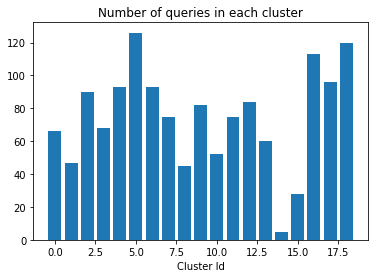

In [25]:
# bincount counts the number of occurences of each number in the array
# i.e., bincount[0] is the # of times 0 occurs 
#       bincount[1] is the # of times 1 occurs 

plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(kmeans_clusters))

### View KMeans results:
- Change "i" to the cluster number 
- All the queries belonging to that cluster will be printed

In [26]:
NUM_CLUSTERS

19

In [27]:
for idx, i in enumerate(kmeans_clusters):
    if i==2:
        print(queries[qids[idx]])
        print("\n")

[3893287, 'select c1.FirstName, c1.LastName, count(distinct p2.PurchaseId)\nfrom Customers c1 natural join Purchases p1, Purchases p2,\n    (select p3.ProductId, min(p3.Price) as cn from Purchases p3 group by p3.ProductId) as tmp\nwhere p1.ProductId = tmp.ProductId and p1.price = tmp.cn and p2.CustomerId = p1.CustomerId\ngroup by p1.CustomerId\norder by p1.CustomerId desc;']


[3893287, 'select FirstName,LastName,count(*)\nfrom Customers natural join Purchases\nwhere CustomerId in\n    (select CustomerId\n    from Customers natural join Purchases as total\n    where Price = \n                (\n                select min(Price) # lowest price for that product\n                from Purchases\n                where ProductId = total.ProductId\n                )\n    group by CustomerId\n    )\ngroup by CustomerId\norder by CustomerId desc']


[3893287, 'SELECT cust.FirstName, cust.LastName, PurchaseCount.numPurchases\nFROM Customers cust, (SELECT CustomerId, COUNT(*) as numPurchases FROM

In [28]:
get_ari(kmeans_clusters, labels)

ARI index: 0.262447996710778


## Mean shift clustering 

This is useful if we don't know the number of clusters that a dataset should have (i.e., we have unlabeled data). 
Mean shift clustering will automatically choose a number of clusters



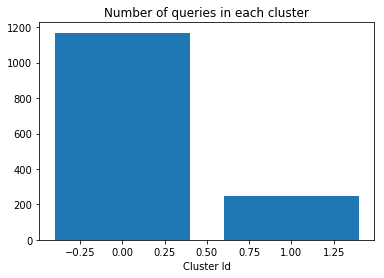

In [172]:
ms_clustering = mean_shift(data)

In [173]:
get_ari(ms_clustering, labels)

ARI index: 0.07493886532438242


## Agglomerative Clustering 

Hierarchical approach. Also good when we don't have a set # of clusters. Aggolmerative means each sample starts in its own cluster, and recursively merges with neighbors depending on a distance/linkage method. 

Types of linkages that we can experiment with (stolen from sklearn): 
- *Ward* minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- *Maximum* or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- *Average* linkage minimizes the average of the distances between all observations of pairs of clusters.
- *Single* linkage minimizes the distance between the closest observations of pairs of clusters.

<BarContainer object of 19 artists>

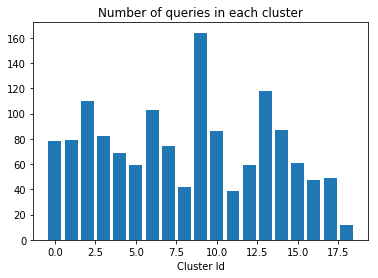

In [54]:
plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(clustering.labels_))

In [175]:
ari = metrics.adjusted_rand_score(labels, clustering.labels_) 
print("ARI index: " + str(ari))

ARI index: 0.30110115899309287


In [ ]:
## old code for spectral clustering and ari index if we have labels 

sp = SpectralClustering(n_clusters=NUM_CLUSTERS,
        assign_labels="discretize",
        random_state=0)
sp.fit(data)


ari = metrics.adjusted_rand_score(labels, clusters) 
print("ARI index: " + str(ari))
print("\n\n")

# labels = zip(readme_docs, clusters)
# np.save("pickles/"+pickle_label+"_labels", labels, allow_pickle=True, fix_imports=True)